### Routine per il fine tuning del modello 

In [1]:
import netCDF4
import numpy as np
import pandas as pd
import geopandas as gpd

from datetime import datetime, timedelta
from tqdm import tqdm
from shapely.geometry import Point

from scipy.stats import skew, kurtosis, entropy

from scipy.fft import fft
from sklearn.preprocessing import MinMaxScaler


import os

from pycaret.classification import setup, load_model, load_experiment, compare_models, tune_model, finalize_model, save_model, plot_model, evaluate_model, dashboard, save_experiment, blend_models, get_config

import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.model_selection import train_test_split




In [2]:
ROOT_DIR = 'E:/data/RONGOWAI_L1_SDR_V1.0/'

In [3]:

class SurfaceTypeUtils:
    surface_type_dict = {
        -1: "Ocean",
        0: "NaN",
        1: "Artifical",
        2: "Barely vegetated",
        3: "Inland water",
        4: "Crop",
        5: "Grass",
        6: "Shrub",
        7: "Forest"
    }
    ddm_antennas = {
        0: 'None',
        1: 'Zenith',
        2: 'LHCP',
        3: 'RHCP',
    }

In [4]:
class NetCDFPreprocessor:
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.netcdf_file_list = os.listdir(root_dir)

    @staticmethod
    def check_integrity(f):
        """Check integrity of the netCDF file"""
        if not isinstance(f, netCDF4.Dataset):
            raise ValueError("Input must be a netCDF4.Dataset object")
        if 'raw_counts' not in f.variables:
            raise KeyError("The netCDF file does not contain 'raw_counts' variable")
        if 'sp_alt' not in f.variables or 'sp_inc_angle' not in f.variables:
            raise KeyError("The netCDF file does not contain 'sp_alt' or 'sp_inc_angle' variables")
        if 'sp_rx_gain_copol' not in f.variables or 'sp_rx_gain_xpol' not in f.variables or 'ddm_snr' not in f.variables:
            raise KeyError("The netCDF file does not contain 'sp_rx_gain_copol', 'sp_rx_gain_xpol' or 'ddm_snr' variables")
        if 'sp_lat' not in f.variables or 'sp_lon' not in f.variables:
            raise KeyError("The netCDF file does not contain 'sp_lat' or 'sp_lon' variables")
        if 'sp_surface_type' not in f.variables:
            raise KeyError("The netCDF file does not contain 'sp_surface_type' variable")
        if 'ac_alt' not in f.variables:
            raise KeyError("The netCDF file does not contain 'ac_alt' variable")
        if f.variables['raw_counts'].ndim != 4:
            raise ValueError("The 'raw_counts' variable must have 4 dimensions")
        
    def preprocess(self, f):
        """ Preprocess the netCDF file and return fit data and labels """
        # Check integrity of the netCDF file
        self.check_integrity(f)
        
        # Carica i dati una volta sola, evitando np.array() non necessario
        raw_counts = f.variables['raw_counts'][:]
        
        # Ottimizzazione 1: Usa broadcasting invece di repeat
        ac_alt = f.variables['ac_alt'][:]
        sp_alt = f.variables['sp_alt'][:]
        sp_inc_angle = f.variables['sp_inc_angle'][:]
        
        # Broadcasting più efficiente (evita repeat)
        distance_2d = (ac_alt[:, np.newaxis] - sp_alt) / np.cos(np.deg2rad(sp_inc_angle))
        
        # Carica tutte le variabili necessarie
        copol = f.variables['sp_rx_gain_copol'][:]
        xpol = f.variables['sp_rx_gain_xpol'][:]
        snr = f.variables['ddm_snr'][:]
        
        
        keep_mask = (
            (copol >= 5) & 
            (xpol >= 5) & 
            (snr > 0) & 
            (distance_2d >= 2000) & 
            (distance_2d <= 10000) &
            ~np.isnan(copol) & 
            ~np.isnan(xpol) & 
            ~np.isnan(snr) & 
            ~np.isnan(distance_2d)
        )
        
        output_array = np.full(raw_counts.shape, np.nan, dtype=np.float32)
        i_indices, j_indices = np.where(keep_mask)
        output_array[i_indices, j_indices] = raw_counts[i_indices, j_indices]
        
        n_time, n_samples = raw_counts.shape[:2]
        raw_counts_reshaped = output_array.reshape(n_time * n_samples, *raw_counts.shape[2:])
        
        valid_mask = ~np.any(np.isnan(raw_counts_reshaped), axis=(1, 2)) & (np.sum(raw_counts_reshaped, axis=(1, 2)) > 0)
        
        fit_data = raw_counts_reshaped[valid_mask].reshape(valid_mask.sum(), -1)
        
        surface_types = np.nan_to_num(f.variables["sp_surface_type"][:], nan=0).ravel()
        label_data = np.isin(surface_types, np.arange(1, 8)).astype(np.int32)
        label_data = label_data[valid_mask]
        
        assert fit_data.shape[0] == len(label_data), \
            f"Shape mismatch: fit_data {fit_data.shape[0]}, label_data {len(label_data)}"
        
        return fit_data, label_data
    
    def preprocess_w_lat_lons(self, f):
        """ Version with latitude and longitude extraction """

        self.check_integrity(f)
        raw_counts = np.array(f.variables['raw_counts'])
                
        # Calcolo distanza tra il punto speculare e l'aereo
        ac_alt_2d = np.repeat(np.array(f.variables['ac_alt'])[:, np.newaxis], 20, axis=1)
        distance_2d = (ac_alt_2d - f.variables['sp_alt'][:]) / np.cos(np.deg2rad(f.variables['sp_inc_angle'][:]))

        # Seleziono gli indici dove sp_rx_gain_copol > 5, sp_rx_gain_xpol > 5 e ddm_snr > 0 e distanza tra punto speculare e antenna > 2000 e < 10000

        copol = f.variables['sp_rx_gain_copol'][:]
        xpol = f.variables['sp_rx_gain_xpol'][:]
        snr = f.variables['ddm_snr'][:]
        dist = distance_2d[:]
        specular_point_lat = f.variables['sp_lat'][:]
        specular_point_lon = f.variables['sp_lon'][:]

        # Filtraggio dei dati
        keep_mask = (copol >= 5) & (xpol >= 5) & (snr > 0) & ((dist >= 2000) & (dist <= 10000)) & (~np.isnan(copol.data) & ~np.isnan(xpol.data) & ~np.isnan(snr.data) & ~np.isnan(dist.data) & ~np.isnan(specular_point_lat.data) & ~np.isnan(specular_point_lon.data))
        to_keep_indices = np.argwhere(keep_mask)
        
        filtered_raw_counts = [raw_counts[i, j] for i, j in to_keep_indices]
        output_array = np.full(raw_counts.shape, np.nan, dtype=np.float32)

        specular_point_lats = specular_point_lat[to_keep_indices[:, 0]]
        specular_point_lons = specular_point_lon[to_keep_indices[:, 0]]
        
        for idx, (i, j) in enumerate(to_keep_indices):
            output_array[i, j] = filtered_raw_counts[idx]
                
            raw_counts_filtered = output_array.copy()

        raw_counts_filtered = output_array.copy()
        del output_array

        ddm_data_dict = {
            'Raw_Counts': raw_counts_filtered.reshape(raw_counts_filtered.shape[0]*raw_counts_filtered.shape[1], raw_counts_filtered.shape[2], raw_counts_filtered.shape[3]),
        }

        keep_indices = np.where(
            np.all(~np.isnan(ddm_data_dict['Raw_Counts']), axis=(1, 2)) & (np.sum(ddm_data_dict['Raw_Counts'], axis=(1, 2)) > 0)
        )[0]
        fit_data = np.array([ddm_data_dict['Raw_Counts'][f].ravel() for f in keep_indices])

        specular_point_lats = specular_point_lat.ravel()[keep_indices]
        specular_point_lons = specular_point_lon.ravel()[keep_indices]
        
        surface_types = f.variables["sp_surface_type"][:]
        surface_types = np.nan_to_num(surface_types, nan=0)
        surface_types_unravelled = surface_types.ravel()
        label_data = [1 if surface_type in np.arange(1, 8) else 0 for surface_type in surface_types_unravelled]
        label_data = [label_data[lab] for lab in range(len(label_data)) if lab in keep_indices]

        assert np.array(fit_data).shape[0] == len(label_data) == np.array(specular_point_lats).shape[0] == np.array(specular_point_lons).shape[0], \
            f"Shape mismatch: fit_data {np.array(fit_data).shape[0]}, label_data {len(label_data)}, lats {np.array(specular_point_lats).shape[0]}, lons {np.array(specular_point_lons).shape[0]}"
        

        return fit_data, label_data, specular_point_lats, specular_point_lons


    def process_all_files(self, chunk_size = int, sample_fraction = float, remove_chunks= bool):
        
        full_data = []
        full_labels = []
        counter = 0
        # Prendi 500 file random dalla lista dei file netCDF
        if len(self.netcdf_file_list) > 500:
            np.random.seed(42)
            random_netcdf_selected_files = np.random.choice(self.netcdf_file_list, 500, replace=False)
            print('Selezionati 500 file netCDF casuali dalla lista')
        else:
            random_netcdf_selected_files = self.netcdf_file_list

        for file_name in tqdm(random_netcdf_selected_files, desc="Processing files"):
            if not file_name.endswith('.nc'):
                continue
            try:
                f = netCDF4.Dataset(f'{self.root_dir}{file_name}')
                data, labels = self.preprocess(f)
                assert (len(data) == len(labels)), f"Data and labels length mismatch in file {file_name}: {len(data)} != {len(labels)}"
                full_data.append(data)
                full_labels.append(labels)
            except Exception as e:
                print(f"Error processing file {file_name}: {e}")
                continue
            counter += 1
            if counter == 500:
                break  # Limita il numero di file processati per test
                
        # Trova gli indici degli elementi di full_data con seconda dimensione uguale a 200
        valid_indices = [i for i, arr in enumerate(full_data) if arr.ndim == 2 if arr.shape[1] == 200]

        # Applica la selezione a full_data e full_labels
        full_data_clean = [full_data[i] for i in valid_indices]
        full_labels_clean = [full_labels[i] for i in valid_indices]
        
        # Chunking 
        os.makedirs('test_data/binary_classification', exist_ok=True)

        chunk_size = chunk_size # dimensione del chunk in numero di campioni
        sample_fraction = sample_fraction # frazione di dati da campionare per ogni chunk

        full_data_sampled = []
        full_labels_sampled = []

        num_chunks = int(np.ceil(len(full_data_clean) / chunk_size))
        print(f"Total number of chunks: {num_chunks}")
        for idx in range(num_chunks):
            start = idx * chunk_size
            end = min((idx + 1) * chunk_size, len(full_data_clean))
            chunk_data = np.vstack(full_data_clean[start:end])
            chunk_labels = np.hstack(full_labels_clean[start:end])
            
            print(f"Chunk {idx + 1}/{num_chunks} processed with shape {chunk_data.shape} and labels shape {chunk_labels.shape}")

            # Salva ogni chunk come file parquet separato
            fit_data_df = pd.DataFrame(chunk_data)
            labels_df = pd.DataFrame(chunk_labels, columns=['label'])

            table_fit = pa.Table.from_pandas(fit_data_df, preserve_index=False)
            table_labels = pa.Table.from_pandas(labels_df, preserve_index=False)

            pq.write_table(
                table_fit,
                f'test_data/binary_classification/fit_data_chunk_{idx}.parquet',
                compression='zstd',
                use_dictionary=True,
            )
            pq.write_table(
                table_labels,
                f'test_data/binary_classification/labels_chunk_{idx}.parquet',
                compression='zstd',
                use_dictionary=True,
            )
            
        # Imposta la frazione di dati da campionare per ogni chunk (es: 0.2 per il 20%)
        
            _, X_sampled, _, y_sampled = train_test_split(
                chunk_data, chunk_labels, 
                test_size=sample_fraction, 
                stratify=chunk_labels, 
                random_state=42
            )

            
            full_data_sampled.append(X_sampled)
            full_labels_sampled.append(y_sampled)

        del full_data, full_labels

        full_data_sampled_stratified = np.vstack(full_data_sampled)
        full_labels_sampled_stratified = np.hstack(full_labels_sampled)

        del full_data_sampled, full_labels_sampled
        print(f"Shape of sampled data after chunking and sampling: {np.array(full_data_sampled_stratified).shape}")
        print(f"Shape of sampled labels after chunking and sampling: {np.array(full_labels_sampled_stratified).shape}")
        
        # Crea la cartella test_data se non esiste
        os.makedirs('test_data/binary_classification', exist_ok=True)

        # Salva fit_data in formato parquet 
        fit_data_df = pd.DataFrame(full_data_sampled_stratified)
        table_fit = pa.Table.from_pandas(fit_data_df, preserve_index=False)
        pq.write_table(
            table_fit,
            'test_data/binary_classification/fit_data_binary_test.parquet',
            compression='zstd',
            use_dictionary=True,
            
        )

        # Salva labels in formato parquet 
        labels_df = pd.DataFrame(full_labels_sampled_stratified, columns=['label'])
        table_labels = pa.Table.from_pandas(labels_df, preserve_index=False)
        pq.write_table(
            table_labels,
            'test_data/binary_classification/labels_binary_test.parquet',
            compression='zstd',
            use_dictionary=True,
            
        )
        del fit_data_df, labels_df, table_fit, table_labels
        
        print("Data and labels saved in test_data/binary_classification directory.")
        # Remove all chunk parquet files if flag is set
        if remove_chunks:
            try:
                chunk_dir = 'test_data/binary_classification'
                for fname in os.listdir(chunk_dir):
                    if fname.startswith('fit_data_chunk_') or fname.startswith('labels_chunk_'):
                        os.remove(os.path.join(chunk_dir, fname))
                print("All chunk files removed.")
            except Exception as e:
                print(f"Error removing chunk files: {e}")

        return full_data_sampled_stratified, full_labels_sampled_stratified

In [5]:
class DDMFeatureExtractor:
    def __init__(self):
        pass
    def gini(self, array):
            """Calcola il coefficiente di Gini (disuguaglianza)"""
            array = np.sort(array)
            index = np.arange(1, array.shape[0] + 1)
            return (np.sum((2 * index - array.shape[0] - 1) * array)) / (array.shape[0] * np.sum(array))    
    def extract_ddm_features(self, fit_data: np.ndarray) -> pd.DataFrame:

        """
        Estrae features dettagliate da raw_counts DDM (shape: n_samples x 200)
        """
        features = []

        for row in tqdm(fit_data, desc="Extracting DDM features"):
            f = {}
            x = np.array(row, dtype=np.float64) + 1e-10  # evita log(0)

            # 1. Statistiche base
            f['mean'] = np.mean(x)
            f['std'] = np.std(x)
            f['min'] = np.min(x)
            f['max'] = np.max(x)
            f['median'] = np.median(x)
            f['range'] = np.max(x) - np.min(x)
            f['skew'] = skew(x)
            f['kurtosis'] = kurtosis(x)
            f['entropy'] = entropy(x)
            f['gini'] = self.gini(x)

            # 2. Posizionali
            f['peak_index'] = np.argmax(x)
            f['peak_value'] = np.max(x)
            f['center_of_mass'] = np.sum(np.arange(len(x)) * x) / np.sum(x)
            f['inertia'] = np.sum(((np.arange(len(x)) - f['center_of_mass'])**2) * x)

            # 3. Segmentazione
            thirds = np.array_split(x, 3)
            for i, part in enumerate(thirds):
                f[f'sum_third_{i+1}'] = np.sum(part)
                f[f'mean_third_{i+1}'] = np.mean(part)
                f[f'max_third_{i+1}'] = np.max(part)
            
            windows = np.array_split(x, 5)
            for i, w in enumerate(windows):
                f[f'mean_w{i+1}'] = np.mean(w)
                f[f'std_w{i+1}'] = np.std(w)
                f[f'max_w{i+1}'] = np.max(w)

            # 4. Derivate e cambiamenti
            dx = np.diff(x)
            f['mean_diff'] = np.mean(dx)
            f['std_diff'] = np.std(dx)
            f['max_diff'] = np.max(dx)
            f['min_diff'] = np.min(dx)
            f['n_positive_diff'] = np.sum(dx > 0)
            f['n_negative_diff'] = np.sum(dx < 0)
            f['n_zero_diff'] = np.sum(dx == 0)

            # 5. Autocorrelazioni (lag 1-3)
            for lag in range(1, 4):
                ac = np.corrcoef(x[:-lag], x[lag:])[0, 1] if len(x) > lag else np.nan
                f[f'autocorr_lag{lag}'] = ac

            # 6. FFT (spettro frequenze)
            spectrum = np.abs(fft(x))
            half_spectrum = spectrum[:len(spectrum)//2]  # simmetrico
            f['fft_peak_freq'] = np.argmax(half_spectrum)
            f['fft_max'] = np.max(half_spectrum)
            f['fft_median'] = np.median(half_spectrum)
            f['fft_mean'] = np.mean(half_spectrum)

            
            #Aggiungi le statistiche dei quadranti e del centro
            ddm = row.reshape(10, 20)  # 10x20

            # Quadranti
            q1 = ddm[:5, :10].ravel()
            q2 = ddm[:5, 10:].ravel()
            q3 = ddm[5:, :10].ravel()
            q4 = ddm[5:, 10:].ravel()
            # Quadrante centrale (4x8 centrale)
            center = ddm[3:7, 6:14].ravel()
            
            # Statistiche dei quadranti 
            f['q1_mean'] = np.mean(q1)
            f['q2_mean'] = np.mean(q2)      
            f['q3_mean'] = np.mean(q3)
            f['q4_mean'] = np.mean(q4)
            f['center_mean'] = np.mean(center)
            f['q1_std'] = np.std(q1)
            f['q2_std'] = np.std(q2)
            f['q3_std'] = np.std(q3)
            f['q4_std'] = np.std(q4)
            f['center_std'] = np.std(center)
            f['q1_min'] = np.min(q1)
            f['q2_min'] = np.min(q2)
            f['q3_min'] = np.min(q3)
            f['q4_min'] = np.min(q4)
            f['center_min'] = np.min(center)
            f['q1_max'] = np.max(q1)
            f['q2_max'] = np.max(q2)
            f['q3_max'] = np.max(q3)
            f['q4_max'] = np.max(q4)
            f['center_max'] = np.max(center)
            f['q1_median'] = np.median(q1)
            f['q2_median'] = np.median(q2)
            f['q3_median'] = np.median(q3)
            f['q4_median'] = np.median(q4)
            f['center_median'] = np.median(center)
            f['q1_range'] = np.max(q1) - np.min(q1)
            f['q2_range'] = np.max(q2) - np.min(q2)
            f['q3_range'] = np.max(q3) - np.min(q3)
            f['q4_range'] = np.max(q4) - np.min(q4)
            f['center_range'] = np.max(center) - np.min(center)
            f['q1_skew'] = skew(q1)
            f['q2_skew'] = skew(q2)
            f['q3_skew'] = skew(q3)
            f['q4_skew'] = skew(q4)
            f['center_skew'] = skew(center)
            f['q1_kurtosis'] = kurtosis(q1)
            f['q2_kurtosis'] = kurtosis(q2)
            f['q3_kurtosis'] = kurtosis(q3)
            f['q4_kurtosis'] = kurtosis(q4)
            f['center_kurtosis'] = kurtosis(center)
            f['q1_entropy'] = entropy(q1 + 1e-10)
            f['q2_entropy'] = entropy(q2 + 1e-10)
            f['q3_entropy'] = entropy(q3 + 1e-10)
            f['q4_entropy'] = entropy(q4 + 1e-10)
            f['center_entropy'] = entropy(center + 1e-10)
            f['q1_gini'] = self.gini(q1)
            f['q2_gini'] = self.gini(q2)
            f['q3_gini'] = self.gini(q3)
            f['q4_gini'] = self.gini(q4)
            f['center_gini'] = self.gini(center)

            # Statistiche di confronto tra quadranti e centro
            
            # Differenze tra media dei quadranti e centro
            f['q1_center_mean_diff'] = f['q1_mean'] - f['center_mean']
            f['q2_center_mean_diff'] = f['q2_mean'] - f['center_mean']
            f['q3_center_mean_diff'] = f['q3_mean'] - f['center_mean']
            f['q4_center_mean_diff'] = f['q4_mean'] - f['center_mean']

            # Differenze tra std dei quadranti e centro
            f['q1_center_std_diff'] = f['q1_std'] - f['center_std']
            f['q2_center_std_diff'] = f['q2_std'] - f['center_std']
            f['q3_center_std_diff'] = f['q3_std'] - f['center_std']
            f['q4_center_std_diff'] = f['q4_std'] - f['center_std']

            # Differenze tra max dei quadranti e centro
            f['q1_center_max_diff'] = f['q1_max'] - f['center_max']
            f['q2_center_max_diff'] = f['q2_max'] - f['center_max']
            f['q3_center_max_diff'] = f['q3_max'] - f['center_max']
            f['q4_center_max_diff'] = f['q4_max'] - f['center_max']

            # Differenze tra min dei quadranti e centro
            f['q1_center_min_diff'] = f['q1_min'] - f['center_min']
            f['q2_center_min_diff'] = f['q2_min'] - f['center_min']
            f['q3_center_min_diff'] = f['q3_min'] - f['center_min']
            f['q4_center_min_diff'] = f['q4_min'] - f['center_min']

            # Differenze tra entropia dei quadranti e centro
            f['q1_center_entropy_diff'] = f['q1_entropy'] - f['center_entropy']
            f['q2_center_entropy_diff'] = f['q2_entropy'] - f['center_entropy']
            f['q3_center_entropy_diff'] = f['q3_entropy'] - f['center_entropy']
            f['q4_center_entropy_diff'] = f['q4_entropy'] - f['center_entropy']

            # Differenze tra gini dei quadranti e centro
            f['q1_center_gini_diff'] = f['q1_gini'] - f['center_gini']
            f['q2_center_gini_diff'] = f['q2_gini'] - f['center_gini']
            f['q3_center_gini_diff'] = f['q3_gini'] - f['center_gini']
            f['q4_center_gini_diff'] = f['q4_gini'] - f['center_gini']

            # Differenze tra skewness dei quadranti e centro
            f['q1_center_skew_diff'] = f['q1_skew'] - f['center_skew']
            f['q2_center_skew_diff'] = f['q2_skew'] - f['center_skew']
            f['q3_center_skew_diff'] = f['q3_skew'] - f['center_skew']
            f['q4_center_skew_diff'] = f['q4_skew'] - f['center_skew']

            # Differenze tra kurtosis dei quadranti e centro
            f['q1_center_kurtosis_diff'] = f['q1_kurtosis'] - f['center_kurtosis']
            f['q2_center_kurtosis_diff'] = f['q2_kurtosis'] - f['center_kurtosis']
            f['q3_center_kurtosis_diff'] = f['q3_kurtosis'] - f['center_kurtosis']
            f['q4_center_kurtosis_diff'] = f['q4_kurtosis'] - f['center_kurtosis']

            features.append(f)
            
        return features

In [6]:
read_from_backup = True
if read_from_backup:
    
    # Leggi i file parquet con polars
    fit_data_pl = pd.read_parquet('C:/Users/atogni/Desktop/rongowai/test_data/binary_classification/fit_data_binary_test.parquet')
    labels_pl = pd.read_parquet('C:/Users/atogni/Desktop/rongowai/test_data/binary_classification/labels_binary_test.parquet')

    # Trasforma in numpy array
    fit_data = fit_data_pl.to_numpy()
    labels = labels_pl['label'].to_numpy()
    del fit_data_pl, labels_pl
else:
    preprocessor = NetCDFPreprocessor(root_dir=ROOT_DIR)
    fit_data, labels = preprocessor.process_all_files(chunk_size=250, sample_fraction=0.9,remove_chunks=True)

In [7]:
num_samples = 2000000 
indices = np.random.choice(fit_data.shape[0], size=num_samples, replace=False)
fit_data = fit_data[indices]
labels = labels[indices]

In [8]:
preprocessor = NetCDFPreprocessor(root_dir=ROOT_DIR)
features_extractor = DDMFeatureExtractor()

In [9]:
from joblib import Parallel, delayed

def extract_ddm_features_row(row):
    return features_extractor.extract_ddm_features(np.array([row]))

combined_features = Parallel(n_jobs=12, backend="loky")(delayed(extract_ddm_features_row)(row) for row in tqdm(fit_data, desc="Estrazione features"))

Estrazione features: 100%|██████████| 2000000/2000000 [13:13<00:00, 2519.28it/s]


In [10]:
flat_features = [row[0] if isinstance(row, list) and len(row) > 0 else row for row in combined_features]
FEATURES = list(flat_features[0].keys())

In [11]:

combined_features = np.array([[row[key] for key in FEATURES] for row in flat_features])
combined_features.shape

# Controlla infiniti o valori troppo grandi per float64
mask_finite = np.isfinite(combined_features).all(axis=1) & (np.abs(combined_features) < np.finfo(np.float64).max).all(axis=1)
fit_data_with_features_clean = combined_features[mask_finite]
labels_clean = labels[mask_finite]


In [ ]:
# cleanup
del labels, fit_data
del combined_features, flat_features

In [13]:
# Salvo le features e le labels in formato parquet
save = True
if save:
    # Crea la cartella processed_data/binary_classification/data_w_features se non esiste
    os.makedirs('processed_data/binary_classification/data_w_features', exist_ok=True)
    pd.DataFrame(fit_data_with_features_clean, columns=FEATURES).to_parquet('test_data/binary_classification/combined_features.parquet', index=False)
    pd.DataFrame(labels_clean).to_parquet('test_data/binary_classification/labels_binary_stats_features_only.parquet', index=False)

In [14]:
# Seleziona un numero uguale di campioni per ciascuna classe per ogni subset
num_subsets = 10
subset_size = 50000

subsets_X = []
subsets_y = []

# Trova gli indici delle due classi
idx_0 = np.where(labels_clean == 0)[0]
idx_1 = np.where(labels_clean == 1)[0]
min_class_size = min(len(idx_0), len(idx_1), subset_size // 2)

for i in range(num_subsets):
    idx_0_sample = np.random.choice(idx_0, size=min_class_size, replace=False)
    idx_1_sample = np.random.choice(idx_1, size=min_class_size, replace=False)
    idx_balanced = np.concatenate([idx_0_sample, idx_1_sample])
    np.random.shuffle(idx_balanced)
    subsets_X.append(fit_data_with_features_clean[idx_balanced])
    subsets_y.append(labels_clean[idx_balanced])

In [15]:
from collections import Counter
# Controlla la distribuzione delle classi in ogni subset
for i, (X, y) in enumerate(zip(subsets_X, subsets_y)):
    print(f"Subset {i+1}: {Counter(y)}")
    

Subset 1: Counter({1: 25000, 0: 25000})
Subset 2: Counter({0: 25000, 1: 25000})
Subset 3: Counter({0: 25000, 1: 25000})
Subset 4: Counter({1: 25000, 0: 25000})
Subset 5: Counter({0: 25000, 1: 25000})
Subset 6: Counter({1: 25000, 0: 25000})
Subset 7: Counter({1: 25000, 0: 25000})
Subset 8: Counter({1: 25000, 0: 25000})
Subset 9: Counter({0: 25000, 1: 25000})
Subset 10: Counter({1: 25000, 0: 25000})


In [27]:
# Controlla che i subset siano tutti diversi tra loro
all_unique = True
for i in range(num_subsets):
    for j in range(i + 1, num_subsets):
        # Confronta gli indici usati per ciascun subset
        set_i = set(subsets_X[i].tobytes())
        set_j = set(subsets_X[j].tobytes())

### Caricamento modelli


In [28]:
xg_boost_model_final = load_model('xgboost_model_final')
best_binary_classification_model = None # load_model('best_binary_classification_model')
best_random_forest_model = None #load_model('best_random_forest_model')
best_binary_classification_ensembled_model = None #load_model('best_binary_classification_ensembled_model')

Transformation Pipeline and Model Successfully Loaded


In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Preprocessing for xg_boost_model_final (dict with scaler and label_encoder)
def preprocess_for_xgboost(X):
    scaler = xg_boost_model_final['scaler']
    return scaler.transform(X)

def predict_with_xgboost(X):
    model = xg_boost_model_final['model']
    X_proc = preprocess_for_xgboost(X)
    return model.predict(X_proc)

# Preprocessing for pycaret pipeline models
def preprocess_for_pycaret(model, X):
    # Applica MinMaxScaler se presente nella pipeline del modello pycaret
    scaler = None
    for name, step in model.named_steps.items():
        if "minmax" in name or "min_max" in name:
            scaler = step
            break
    if scaler is not None:
        X = scaler.transform(X)
    return X
    #X = model.transform(X)
    #feature_names = [f"features_{i+1}" for i in range(len(FEATURES))]
    #return pd.DataFrame(X)
    pass
    
def predict_with_pycaret(model, X):
    #X_proc = preprocess_for_pycaret(model, X)
    return model.predict(X)

# Preprocessing for sklearn models (e.g., RandomForest)
def preprocess_for_sklearn(X):
    # Assume features are already in correct format
    return X

def predict_with_sklearn(model, X):
    X_proc = preprocess_for_sklearn(X)
    return model.predict(X_proc)



=== XGBoost Model Final ===
Subset 1: Accuracy = 0.8491
Confusion Matrix:
[[19278  5722]
 [ 1822 23178]]
Subset 2: Accuracy = 0.8458
Confusion Matrix:
[[19100  5900]
 [ 1812 23188]]
Subset 3: Accuracy = 0.8475
Confusion Matrix:
[[19234  5766]
 [ 1860 23140]]
Subset 4: Accuracy = 0.8491
Confusion Matrix:
[[19289  5711]
 [ 1836 23164]]
Subset 5: Accuracy = 0.8473
Confusion Matrix:
[[19148  5852]
 [ 1782 23218]]
Subset 6: Accuracy = 0.8473
Confusion Matrix:
[[19220  5780]
 [ 1855 23145]]
Subset 7: Accuracy = 0.8469
Confusion Matrix:
[[19183  5817]
 [ 1837 23163]]
Subset 8: Accuracy = 0.8462
Confusion Matrix:
[[19196  5804]
 [ 1885 23115]]
Subset 9: Accuracy = 0.8489
Confusion Matrix:
[[19229  5771]
 [ 1785 23215]]
Subset 10: Accuracy = 0.8483
Confusion Matrix:
[[19266  5734]
 [ 1851 23149]]
Mean Accuracy: 0.8476
Std Accuracy: 0.0011
Classification Report (last subset):
              precision    recall  f1-score   support

           0       0.91      0.77      0.84     25000
           

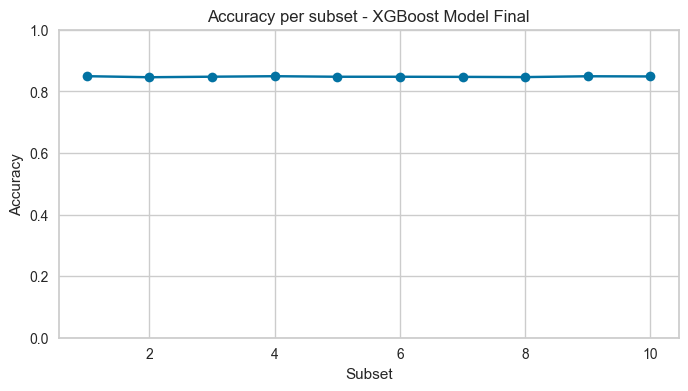

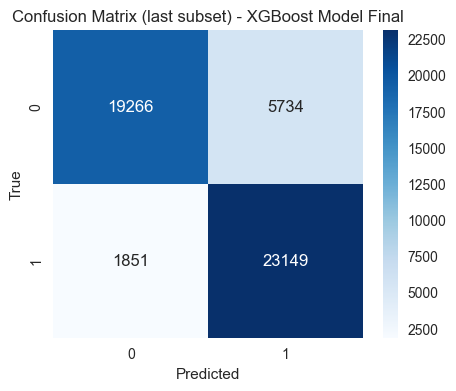

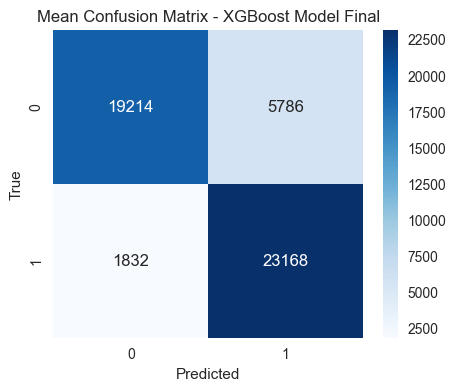

In [32]:
from sklearn.metrics import roc_curve
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd


# Build models dict with wrappers for preprocessing
models = {}

if isinstance(xg_boost_model_final, dict):
    models["XGBoost Model Final"] = type(
        "XGBWrapper", (), {"predict": staticmethod(predict_with_xgboost)}
    )()

if best_binary_classification_model is not None:
    models["Best Binary Classification Model"] = type(
        "PyCaretWrapper", (), {"predict": staticmethod(lambda X: predict_with_pycaret(best_binary_classification_model, X))}
    )()

if best_random_forest_model is not None:
    models["Best Random Forest Model"] = type(
        "RFWrapper", (), {"predict": staticmethod(lambda X: predict_with_sklearn(best_random_forest_model, X))}
    )()

if best_binary_classification_ensembled_model is not None:
    models["Best Binary Classification Ensembled Model"] = type(
        "PyCaretEnsembleWrapper", (), {"predict": staticmethod(lambda X: predict_with_pycaret(best_binary_classification_ensembled_model, X))}
    )()

for model_name, model in models.items():
    print(f"\n=== {model_name} ===")
    accs = []
    cms = []
    for i in range(num_subsets):
        X = subsets_X[i]
        y = subsets_y[i]
        
        # Ricerca della soglia ottimale per la classificazione binaria (solo se il modello supporta predict_proba)
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X)[:, 1]
            fpr, tpr, thresholds = roc_curve(y, y_proba)
            # Soglia ottimale: massimizza tpr - fpr (Youden's J statistic)
            optimal_idx = np.argmax(tpr - fpr)
            optimal_threshold = thresholds[optimal_idx]
            print(f"Optimal threshold: {optimal_threshold:.4f}")
            y_pred = (y_proba >= optimal_threshold).astype(int)
        else:
            y_pred = model.predict(X)

        #y_pred = model.predict(X)
        acc = accuracy_score(y, y_pred)
        cm = confusion_matrix(y, y_pred)
        print(f"Subset {i+1}: Accuracy = {acc:.4f}")
        print(f"Confusion Matrix:\n{cm}")
        accs.append(acc)
        cms.append(cm)
    print(f"Mean Accuracy: {np.mean(accs):.4f}")
    print(f"Std Accuracy: {np.std(accs):.4f}")
    print("Classification Report (last subset):")
    print(classification_report(subsets_y[-1], model.predict(subsets_X[-1])))
    # Media delle accuratezze e confusion matrix media
    mean_acc = np.mean(accs)
    std_acc = np.std(accs)
    mean_cm = np.mean(np.array(cms), axis=0)
    print(f"\nMedia accuratezze: {mean_acc:.4f} ± {std_acc:.4f}")
    print(f"Confusion Matrix media:\n{mean_cm.astype(int)}")
    import matplotlib.pyplot as plt

    # Plot accuracy per subset
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, num_subsets + 1), accs, marker='o')
    plt.title(f'Accuracy per subset - {model_name}')
    plt.xlabel('Subset')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

    # Plot confusion matrix (last subset)
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(subsets_y[-1], model.predict(subsets_X[-1])), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (last subset) - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Plot mean confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(mean_cm, annot=True, fmt='.0f', cmap='Blues')
    plt.title(f'Mean Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    # Calcola il classification report medio su tutti i subset

    reports = []
    for i in range(num_subsets):
        y_true = subsets_y[i]
        y_pred = model.predict(subsets_X[i])
        report = classification_report(y_true, y_pred, output_dict=True)
        reports.append(report)

    